In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("stl10_final.csv", header = None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,27639,27640,27641,27642,27643,27644,27645,27646,27647,27648
0,146,143,110,146,143,110,146,143,110,146,...,138,127,119,147,136,122,138,128,93,1
1,129,140,73,124,133,68,138,144,84,144,...,146,128,94,151,130,91,194,164,123,0
2,179,223,114,163,203,104,165,191,103,89,...,124,149,128,114,140,117,104,131,109,1
3,14,18,29,16,21,35,14,21,41,12,...,125,80,18,123,80,18,120,80,18,0
4,147,130,91,200,189,164,127,112,89,68,...,147,131,89,145,129,93,155,138,108,0


In [4]:
X = df.iloc[:, 0:-1].to_numpy()
Y = df.iloc[:, -1].to_numpy()
X = X / 256.0

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import Optimizer
import timeit

In [6]:
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [7]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X), torch.FloatTensor(Y))
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 27648.
        self.layer_1 = nn.Linear(27648, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.layer_out(x)
        
        return x

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [10]:
class SGD_Simple(Optimizer):
    
    def __init__(self, params, lr, weight_decay=0.0):
        
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
            
        defaults = dict(lr=lr, weight_decay=weight_decay)
        
        super(SGD_Simple, self).__init__(params, defaults)

    def step(self):

        for group in self.param_groups:
            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                    
                p.data.add_(-group['lr'], d_p)

In [11]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [16]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = SGD_Simple(model.parameters(), lr = 0.002)

BinaryClassification(
  (layer_1): Linear(in_features=27648, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [17]:
learning_rate_list = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]

In [25]:
torch.save(model.state_dict(), "/data/sz533/nysnewton/initialmodel.pth")

In [ ]:
timelist_sgd = []
losslist_sgd = []
acclist_sgd = []
for learning_rate in learning_rate_list:
    
    model = BinaryClassification()
    model.load_state_dict(torch.load("/data/sz533/nysnewton/initialmodel.pth"))
    model.to(device)
    
    optimizer = SGD_Simple(model.parameters(), lr = learning_rate)

    timelist = []
    losslist = []
    acclist = []

    start_time = timeit.default_timer()
    
    model.train()
    for e in range(1, 200+1):
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_time = timeit.default_timer()

        print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
        losslist.append(epoch_loss/len(train_loader))
        timelist.append(epoch_time - start_time)
        acclist.append(epoch_acc/len(train_loader))
    
    timelist_sgd.append(timelist)
    losslist_sgd.append(losslist)
    acclist_sgd.append(acclist)

Epoch 001: | Loss: 0.57967 | Acc: 77.230
Epoch 002: | Loss: 0.53667 | Acc: 80.054
Epoch 003: | Loss: 0.53055 | Acc: 80.025
Epoch 004: | Loss: 0.52464 | Acc: 80.069
Epoch 005: | Loss: 0.52013 | Acc: 80.015
Epoch 006: | Loss: 0.51447 | Acc: 79.941
Epoch 007: | Loss: 0.50765 | Acc: 80.069
Epoch 008: | Loss: 0.50236 | Acc: 80.015
Epoch 009: | Loss: 0.49651 | Acc: 80.157
Epoch 010: | Loss: 0.49194 | Acc: 80.225
Epoch 011: | Loss: 0.48781 | Acc: 80.520
Epoch 012: | Loss: 0.48534 | Acc: 80.877
Epoch 013: | Loss: 0.48218 | Acc: 81.245
Epoch 014: | Loss: 0.47978 | Acc: 81.485
Epoch 015: | Loss: 0.47622 | Acc: 81.917
Epoch 016: | Loss: 0.47688 | Acc: 81.912
Epoch 017: | Loss: 0.47153 | Acc: 82.230
Epoch 018: | Loss: 0.46964 | Acc: 82.338
Epoch 019: | Loss: 0.46850 | Acc: 82.515
Epoch 020: | Loss: 0.46649 | Acc: 82.529
Epoch 021: | Loss: 0.46306 | Acc: 82.779
Epoch 022: | Loss: 0.46320 | Acc: 82.593
Epoch 023: | Loss: 0.45944 | Acc: 82.799
Epoch 024: | Loss: 0.45849 | Acc: 82.686
Epoch 025: | Los

Epoch 001: | Loss: 0.55960 | Acc: 78.422
Epoch 002: | Loss: 0.52812 | Acc: 80.020
Epoch 003: | Loss: 0.51709 | Acc: 80.069
Epoch 004: | Loss: 0.50639 | Acc: 80.059
Epoch 005: | Loss: 0.49804 | Acc: 79.936
Epoch 006: | Loss: 0.48992 | Acc: 80.093
Epoch 007: | Loss: 0.48483 | Acc: 80.255
Epoch 008: | Loss: 0.48028 | Acc: 81.172
Epoch 009: | Loss: 0.47627 | Acc: 82.015
Epoch 010: | Loss: 0.47145 | Acc: 82.368
Epoch 011: | Loss: 0.46657 | Acc: 82.490
Epoch 012: | Loss: 0.46250 | Acc: 82.642
Epoch 013: | Loss: 0.45718 | Acc: 82.868
Epoch 014: | Loss: 0.45295 | Acc: 83.000
Epoch 015: | Loss: 0.44967 | Acc: 82.931
Epoch 016: | Loss: 0.44548 | Acc: 83.181
Epoch 017: | Loss: 0.44069 | Acc: 83.319
Epoch 018: | Loss: 0.43735 | Acc: 83.407


In [48]:
len(timelist_sgd)

20

In [ ]:
timelist_adam = []
losslist_adam = []
acclist_adam = []
for learning_rate in learning_rate_list:
    
    model = BinaryClassification()
    model.load_state_dict(torch.load("/data/sz533/nysnewton/initialmodel.pth"))
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    timelist = []
    losslist = []
    acclist = []

    start_time = timeit.default_timer()
    
    model.train()
    for e in range(1, 200+1):
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_time = timeit.default_timer()
        
        if e % 40 == 0:
            print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

        losslist.append(epoch_loss/len(train_loader))
        timelist.append(epoch_time - start_time)
        acclist.append(epoch_acc/len(train_loader))
    
    timelist_sgd.append(timelist)
    losslist_sgd.append(losslist)
    acclist_sgd.append(acclist)

Epoch 040: | Loss: 0.27554 | Acc: 88.480
Epoch 080: | Loss: 0.14297 | Acc: 94.034
Epoch 120: | Loss: 0.11477 | Acc: 95.441
Epoch 160: | Loss: 0.21955 | Acc: 90.608


In [32]:
def group_product(xs, ys):
    
    return sum([torch.sum(x * y) for (x, y) in zip(xs, ys)])

def normalization(v):
    # normalize a vector
    
    s = group_product(v, v)
    s = s**0.5
    s = s.cpu().item()
    v = [vi / (s + 1e-6) for vi in v]
    return v

In [33]:
class NysHessianpartial():
    
    def __init__(self, rank, rho):
        self.rank = rank
        # rho is the regularization in Nystrom sketch
        self.rho = rho
    
    def get_params_grad(self, model):
        # get parameters and differentiation
        params = []
        grads = []
        for param in model.parameters():
            if not param.requires_grad:
                continue
            params.append(param)
            grads.append(0. if param.grad is None else param.grad + 0.)
        return params, grads
    
    def update_Hessian(self, X_batch, y_batch, model, criterion, device):
        
        shift = 0.001
        # get the model parameters and gradients
        params, gradsH = self.get_params_grad(model)
        # remember the size for each group of parameters
        self.size_vec = [p.size() for p in params]
        # store random gaussian vector to a matrix
        test_matrix = []
        # Hessian vector product
        hv_matrix = []
        
        for i in range(self.rank):
            # generate gaussian random vector
            v = [torch.randn(p.size()).to(device) for p in params]
            # normalize
            v = normalization(v)
            # zero vector to store the shape
            hv_add = [torch.zeros(p.size()).to(device) for p in params]
        
            # update hessian with a subsample batch
            
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            model.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            loss.backward(create_graph=True)
            params, gradsH = self.get_params_grad(model)
            # calculate the Hessian vector product
            hv = torch.autograd.grad(gradsH, params, grad_outputs=v,only_inputs=True,retain_graph=True)
            # add initial shift
            for i in range(len(hv)):
                hv_add[i].data = hv[i].data.add_(hv_add[i].data)    
                hv_add[i].data = hv_add[i].data.add_(v[i].data * torch.tensor(shift)) 
            
            # reshape the Hessian vector product into a long vector
            hv_ex = torch.cat([gi.view(-1) for gi in hv_add])
            # reshape the random vector into a long vector
            test_ex = torch.cat([gi.view(-1) for gi in v])
            
            # append long vectors into a large matrix
            hv_matrix.append(hv_ex)
            test_matrix.append(test_ex)
        
        # assemble the large matrix
        hv_matrix_ex = torch.column_stack(hv_matrix)
        test_matrix_ex = torch.column_stack(test_matrix)
        # calculate Omega^T * A * Omega for Cholesky
        choleskytarget = torch.mm(test_matrix_ex.t(), hv_matrix_ex)
        # perform Cholesky, if fails, do eigendecomposition
        # the new shift is the abs of smallest eigenvalue (negative) plus the original shift
        try:
            C_ex = torch.linalg.cholesky(choleskytarget)
        except:
            # eigendecomposition, eigenvalues and eigenvector matrix
            eigs, eigvectors = torch.linalg.eigh(choleskytarget)
            shift = shift + torch.abs(torch.min(eigs))
            # add shift to eigenvalues
            eigs = eigs + shift
            # put back the matrix for Cholesky by eigenvector * eigenvalues after shift * eigenvector^T 
            C_ex = torch.linalg.cholesky(torch.mm(eigvectors, torch.mm(torch.diag(eigs), eigvectors.T)))
        
        # triangular solve
        B_ex = torch.linalg.solve_triangular(C_ex, hv_matrix_ex, upper = False, left = False)
        # SVD
        U, S, V = torch.linalg.svd(B_ex, full_matrices = False)
        self.U = U
        self.S = torch.max(torch.square(S) - torch.tensor(shift), torch.tensor(0.0))
        

In [34]:
class NysHessianOpt(Optimizer):
    r"""Implements NysHessian.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        rank (int): sketch rank
        rho: regularization
    """
    def __init__(self, params, lr, rank = 100, rho = 0.5):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        # initialize the optimizer    
        defaults = dict(lr=lr, rank = rank, rho = rho)
        self.nysh = NysHessianpartial(rank, rho)
        super(NysHessianOpt, self).__init__(params, defaults)
         
    def step(self):
        # one step update
        for group in self.param_groups:
            rho = group['rho']
            # compute gradient as a long vector
            g = torch.cat([p.grad.view(-1) for p in group['params']])
            # calculate the search direction by Nystrom sketch and solve
            UTg = torch.mv(self.nysh.U.t(), g) 
            g_new = torch.mv(self.nysh.U, (self.nysh.S + rho).reciprocal() * UTg) + g / rho - torch.mv(self.nysh.U, UTg) / rho            
            ls = 0
            # update model parameters
            for p in group['params']:
                gp = g_new[ls:ls+torch.numel(p)].view(p.shape)
                ls += torch.numel(p)
                p.data.add_(-group['lr'] * gp)

In [ ]:
hes_interval = 300
# update Hessian and Nystrom sketch every couple of steps

timelist_nyssolve_2 = []
losslist_nyssolve_2 = []
acclist_nyssolve_2 = []
for learning_rate in learning_rate_list:
    
    model = BinaryClassification()
    model.load_state_dict(torch.load("/data/sz533/nysnewton/initialmodel.pth"))
    model.to(device)
    
    optimizer = optimizer = NysHessianOpt(model.parameters(), lr = learning_rate)

    hes_iter = 0

    timelist2 = []
    losslist2 = []
    acclist2 = []

    start_time = timeit.default_timer()

    model.train()
    for e in range(1, EPOCHS+1):
        epoch_loss = 0
        epoch_acc = 0

        for X_batch, y_batch in train_loader:

            if hes_iter % hes_interval == 0:
                # update Hessian and sketch
                optimizer.nysh.update_Hessian(X_batch, y_batch, model, criterion, device)

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            hes_iter += 1
            epoch_time = timeit.default_timer()

        print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
        losslist2.append(epoch_loss/len(train_loader))
        timelist2.append(epoch_time - start_time)
        acclist2.append(epoch_acc/len(train_loader))
    
    timelist_nyssolve_2.append(timelist2)
    losslist_nyssolve_2.append(losslist2)
    acclist_nyssolve_2.append(acclist2)

<ipython-input-33-3030989fd95c>:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.S = torch.max(torch.square(S) - torch.tensor(shift), torch.tensor(0.0))


Epoch 001: | Loss: 0.57785 | Acc: 74.961
Epoch 002: | Loss: 0.52462 | Acc: 80.034
Epoch 003: | Loss: 0.50990 | Acc: 80.034
Epoch 004: | Loss: 0.49697 | Acc: 80.387
Epoch 005: | Loss: 0.48985 | Acc: 80.975
Epoch 006: | Loss: 0.48271 | Acc: 81.637
Epoch 007: | Loss: 0.47461 | Acc: 82.265
Epoch 008: | Loss: 0.47088 | Acc: 82.343
Epoch 009: | Loss: 0.46622 | Acc: 82.495
Epoch 010: | Loss: 0.46386 | Acc: 82.500
Epoch 011: | Loss: 0.45989 | Acc: 82.652
Epoch 012: | Loss: 0.45752 | Acc: 82.711
Epoch 013: | Loss: 0.45453 | Acc: 82.809
Epoch 014: | Loss: 0.45185 | Acc: 82.887
Epoch 015: | Loss: 0.44858 | Acc: 82.961
Epoch 016: | Loss: 0.44611 | Acc: 82.995
Epoch 017: | Loss: 0.44197 | Acc: 83.172
Epoch 018: | Loss: 0.44010 | Acc: 83.270
Epoch 019: | Loss: 0.43760 | Acc: 83.279
Epoch 020: | Loss: 0.43418 | Acc: 83.431
Epoch 021: | Loss: 0.43135 | Acc: 83.529
Epoch 022: | Loss: 0.42880 | Acc: 83.691
Epoch 023: | Loss: 0.42409 | Acc: 83.809
Epoch 024: | Loss: 0.42251 | Acc: 83.902
Epoch 025: | Los

Epoch 001: | Loss: 0.54114 | Acc: 78.206
Epoch 002: | Loss: 0.49365 | Acc: 80.485
Epoch 003: | Loss: 0.47219 | Acc: 82.299
Epoch 004: | Loss: 0.46078 | Acc: 82.676
Epoch 005: | Loss: 0.45201 | Acc: 82.877
Epoch 006: | Loss: 0.44189 | Acc: 83.078
Epoch 007: | Loss: 0.43277 | Acc: 83.461
Epoch 008: | Loss: 0.42541 | Acc: 83.716
Epoch 009: | Loss: 0.41858 | Acc: 84.005
Epoch 010: | Loss: 0.41112 | Acc: 84.304
Epoch 011: | Loss: 0.40243 | Acc: 84.505
Epoch 012: | Loss: 0.39577 | Acc: 84.809
Epoch 013: | Loss: 0.39157 | Acc: 84.750
Epoch 014: | Loss: 0.38547 | Acc: 85.098
Epoch 015: | Loss: 0.37962 | Acc: 85.167
Epoch 016: | Loss: 0.37391 | Acc: 85.412
Epoch 017: | Loss: 0.36756 | Acc: 85.647
Epoch 018: | Loss: 0.36096 | Acc: 85.775
Epoch 019: | Loss: 0.35523 | Acc: 86.088
Epoch 020: | Loss: 0.35226 | Acc: 86.093
Epoch 021: | Loss: 0.34413 | Acc: 86.270
Epoch 022: | Loss: 0.33766 | Acc: 86.632
Epoch 023: | Loss: 0.32966 | Acc: 86.809
Epoch 024: | Loss: 0.32463 | Acc: 87.005
Epoch 025: | Los

Epoch 001: | Loss: 0.52966 | Acc: 78.819
Epoch 002: | Loss: 0.47810 | Acc: 81.833
Epoch 003: | Loss: 0.45726 | Acc: 82.745
Epoch 004: | Loss: 0.44460 | Acc: 83.118
Epoch 005: | Loss: 0.43229 | Acc: 83.525
Epoch 006: | Loss: 0.41963 | Acc: 83.975
Epoch 007: | Loss: 0.40956 | Acc: 84.299
Epoch 008: | Loss: 0.39972 | Acc: 84.603
Epoch 009: | Loss: 0.39004 | Acc: 84.794
Epoch 010: | Loss: 0.38149 | Acc: 85.083
Epoch 011: | Loss: 0.37369 | Acc: 85.422
Epoch 012: | Loss: 0.36471 | Acc: 85.672
Epoch 013: | Loss: 0.35631 | Acc: 86.044
Epoch 014: | Loss: 0.34723 | Acc: 86.176
Epoch 015: | Loss: 0.33758 | Acc: 86.539
Epoch 016: | Loss: 0.32832 | Acc: 86.873
Epoch 017: | Loss: 0.32123 | Acc: 87.088
Epoch 018: | Loss: 0.31355 | Acc: 87.181
Epoch 019: | Loss: 0.30333 | Acc: 87.892
Epoch 020: | Loss: 0.29370 | Acc: 88.485
Epoch 021: | Loss: 0.28626 | Acc: 88.490
Epoch 022: | Loss: 0.27574 | Acc: 89.240
Epoch 023: | Loss: 0.26418 | Acc: 89.755
Epoch 024: | Loss: 0.25407 | Acc: 89.897
Epoch 025: | Los

Epoch 100: | Loss: 0.39102 | Acc: 90.980
Epoch 001: | Loss: 0.51044 | Acc: 79.848
Epoch 002: | Loss: 0.46557 | Acc: 82.368
Epoch 003: | Loss: 0.44581 | Acc: 83.191
Epoch 004: | Loss: 0.42244 | Acc: 83.917
Epoch 005: | Loss: 0.40660 | Acc: 84.363
Epoch 006: | Loss: 0.39430 | Acc: 84.716
Epoch 007: | Loss: 0.38412 | Acc: 84.990
Epoch 008: | Loss: 0.37362 | Acc: 85.123
Epoch 009: | Loss: 0.36203 | Acc: 85.578
Epoch 010: | Loss: 0.34957 | Acc: 85.995
Epoch 011: | Loss: 0.34030 | Acc: 86.431
Epoch 012: | Loss: 0.33145 | Acc: 86.662
Epoch 013: | Loss: 0.31552 | Acc: 87.471
Epoch 014: | Loss: 0.30647 | Acc: 87.892
Epoch 015: | Loss: 0.29309 | Acc: 88.240
Epoch 016: | Loss: 0.28221 | Acc: 88.775
Epoch 017: | Loss: 0.26792 | Acc: 89.113
Epoch 018: | Loss: 0.25460 | Acc: 90.029
Epoch 019: | Loss: 0.24679 | Acc: 90.338
Epoch 020: | Loss: 0.23165 | Acc: 90.863
Epoch 021: | Loss: 0.21776 | Acc: 91.956
Epoch 022: | Loss: 0.20470 | Acc: 92.265
Epoch 023: | Loss: 0.18912 | Acc: 93.029
Epoch 024: | Los

In [109]:
len(timelist_nyssolve_2)

10

In [37]:
class NysHessianPSGD(Optimizer):
    r"""Implements NysHessian.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        rank (int): sketch rank
        rho: regularization
    """
    def __init__(self, params, lr, rank = 100, rho = 0.5):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        # initialize the optimizer    
        defaults = dict(lr=lr, rank = rank, rho = rho)
        self.nysh = NysHessianpartial(rank, rho)
        super(NysHessianPSGD, self).__init__(params, defaults)
         
    def step(self):
        # one step update
        for group in self.param_groups:
            rho = group['rho']
            # compute gradient as a long vector
            g = torch.cat([p.grad.view(-1) for p in group['params']])
            # calculate the search direction by Nystrom preconditioned gradient descent
            UTg = torch.mv(self.nysh.U.t(), g) 
            g_new = torch.mv(self.nysh.U, (self.nysh.S + rho).reciprocal() * UTg) * (torch.min(self.nysh.S) + rho) + g - torch.mv(self.nysh.U, UTg)            
            ls = 0
            # update model parameters
            for p in group['params']:
                gp = g_new[ls:ls+torch.numel(p)].view(p.shape)
                ls += torch.numel(p)
                p.data.add_(-group['lr'] * gp)

In [ ]:
hes_interval = 190
# update Hessian and Nystrom sketch every couple of steps

timelist_nyspsgd = []
losslist_nyspsgd = []
acclist_nyspsgd = []
for learning_rate in learning_rate_list:
    
    model = BinaryClassification()
    model.load_state_dict(torch.load("/data/sz533/nysnewton/initialmodel.pth"))
    model.to(device)
    
    optimizer = optimizer = NysHessianPSGD(model.parameters(), lr = learning_rate)

    hes_iter = 0

    timelist2 = []
    losslist2 = []
    acclist2 = []

    start_time = timeit.default_timer()

    model.train()
    for e in range(1, EPOCHS+1):
        epoch_loss = 0
        epoch_acc = 0

        for X_batch, y_batch in train_loader:

            if hes_iter % hes_interval == 0:
                # update Hessian and sketch
                optimizer.nysh.update_Hessian(X_batch, y_batch, model, criterion, device)

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            hes_iter += 1
            epoch_time = timeit.default_timer()

        print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
        losslist2.append(epoch_loss/len(train_loader))
        timelist2.append(epoch_time - start_time)
        acclist2.append(epoch_acc/len(train_loader))
    
    timelist_nyspsgd.append(timelist2)
    losslist_nyspsgd.append(losslist2)
    acclist_nyspsgd.append(acclist2)

<ipython-input-33-3030989fd95c>:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.S = torch.max(torch.square(S) - torch.tensor(shift), torch.tensor(0.0))


Epoch 001: | Loss: 0.61440 | Acc: 70.882
Epoch 002: | Loss: 0.54332 | Acc: 79.946
Epoch 003: | Loss: 0.53199 | Acc: 80.054
Epoch 004: | Loss: 0.52272 | Acc: 80.088
Epoch 005: | Loss: 0.51453 | Acc: 80.108
Epoch 006: | Loss: 0.50815 | Acc: 80.103
Epoch 007: | Loss: 0.50128 | Acc: 80.294
Epoch 008: | Loss: 0.49449 | Acc: 80.809
Epoch 009: | Loss: 0.48789 | Acc: 81.353
Epoch 010: | Loss: 0.48480 | Acc: 81.647
Epoch 011: | Loss: 0.48047 | Acc: 81.887
Epoch 012: | Loss: 0.47609 | Acc: 82.240
Epoch 013: | Loss: 0.47333 | Acc: 82.363
Epoch 014: | Loss: 0.47194 | Acc: 82.397
Epoch 015: | Loss: 0.47037 | Acc: 82.471
Epoch 016: | Loss: 0.46703 | Acc: 82.676
Epoch 017: | Loss: 0.46515 | Acc: 82.662
Epoch 018: | Loss: 0.46339 | Acc: 82.701
Epoch 019: | Loss: 0.46366 | Acc: 82.598
Epoch 020: | Loss: 0.46124 | Acc: 82.657
Epoch 021: | Loss: 0.45886 | Acc: 82.725
Epoch 022: | Loss: 0.45580 | Acc: 82.858
Epoch 023: | Loss: 0.45444 | Acc: 82.873
Epoch 024: | Loss: 0.45403 | Acc: 82.877
Epoch 025: | Los

Epoch 001: | Loss: 0.56575 | Acc: 76.686
Epoch 002: | Loss: 0.51625 | Acc: 79.980
Epoch 003: | Loss: 0.49639 | Acc: 80.471
Epoch 004: | Loss: 0.48150 | Acc: 81.515
Epoch 005: | Loss: 0.47444 | Acc: 82.078
Epoch 006: | Loss: 0.46700 | Acc: 82.554
Epoch 007: | Loss: 0.46241 | Acc: 82.652
Epoch 008: | Loss: 0.45874 | Acc: 82.706
Epoch 009: | Loss: 0.45774 | Acc: 82.652
Epoch 010: | Loss: 0.45159 | Acc: 82.765
Epoch 011: | Loss: 0.44848 | Acc: 82.848
Epoch 012: | Loss: 0.44413 | Acc: 83.108
Epoch 013: | Loss: 0.43806 | Acc: 83.309
Epoch 014: | Loss: 0.43450 | Acc: 83.441
Epoch 015: | Loss: 0.43001 | Acc: 83.696
Epoch 016: | Loss: 0.42486 | Acc: 83.882
Epoch 017: | Loss: 0.42005 | Acc: 83.961
Epoch 018: | Loss: 0.41541 | Acc: 84.069
Epoch 019: | Loss: 0.41155 | Acc: 84.289
Epoch 020: | Loss: 0.40734 | Acc: 84.343
Epoch 021: | Loss: 0.40507 | Acc: 84.446
Epoch 022: | Loss: 0.40071 | Acc: 84.529
Epoch 023: | Loss: 0.39634 | Acc: 84.696
Epoch 024: | Loss: 0.39462 | Acc: 84.721
Epoch 025: | Los

Epoch 001: | Loss: 0.54480 | Acc: 77.956
Epoch 002: | Loss: 0.48690 | Acc: 81.299
Epoch 003: | Loss: 0.47052 | Acc: 82.456
Epoch 004: | Loss: 0.46084 | Acc: 82.652
Epoch 005: | Loss: 0.45429 | Acc: 82.740
Epoch 006: | Loss: 0.44879 | Acc: 82.814
Epoch 007: | Loss: 0.44075 | Acc: 83.064
Epoch 008: | Loss: 0.43246 | Acc: 83.505
Epoch 009: | Loss: 0.42808 | Acc: 83.691
Epoch 010: | Loss: 0.41885 | Acc: 83.936
Epoch 011: | Loss: 0.41221 | Acc: 84.216
Epoch 012: | Loss: 0.40608 | Acc: 84.368
Epoch 013: | Loss: 0.40051 | Acc: 84.505
Epoch 014: | Loss: 0.39637 | Acc: 84.608
Epoch 015: | Loss: 0.38952 | Acc: 84.936
Epoch 016: | Loss: 0.38567 | Acc: 85.034
Epoch 017: | Loss: 0.37932 | Acc: 85.123
Epoch 018: | Loss: 0.37687 | Acc: 85.147
Epoch 019: | Loss: 0.36835 | Acc: 85.544
Epoch 020: | Loss: 0.36278 | Acc: 85.657
Epoch 021: | Loss: 0.35694 | Acc: 85.814
Epoch 022: | Loss: 0.35102 | Acc: 86.054
Epoch 023: | Loss: 0.34558 | Acc: 86.230
Epoch 024: | Loss: 0.33926 | Acc: 86.554
Epoch 025: | Los

Epoch 001: | Loss: 0.53588 | Acc: 78.647
Epoch 002: | Loss: 0.48982 | Acc: 81.245
Epoch 003: | Loss: 0.47222 | Acc: 82.265
Epoch 004: | Loss: 0.46073 | Acc: 82.667
Epoch 005: | Loss: 0.45082 | Acc: 82.897
Epoch 006: | Loss: 0.44423 | Acc: 82.956
Epoch 007: | Loss: 0.43129 | Acc: 83.598
Epoch 008: | Loss: 0.42168 | Acc: 83.926
Epoch 009: | Loss: 0.41439 | Acc: 84.069
Epoch 010: | Loss: 0.40771 | Acc: 84.314
Epoch 011: | Loss: 0.39972 | Acc: 84.495
Epoch 012: | Loss: 0.39208 | Acc: 84.745
Epoch 013: | Loss: 0.38658 | Acc: 84.931
Epoch 014: | Loss: 0.37913 | Acc: 85.181
Epoch 015: | Loss: 0.37303 | Acc: 85.422
Epoch 016: | Loss: 0.36619 | Acc: 85.431
Epoch 017: | Loss: 0.35929 | Acc: 85.696
Epoch 018: | Loss: 0.35311 | Acc: 85.838
Epoch 019: | Loss: 0.34538 | Acc: 86.328
Epoch 020: | Loss: 0.34034 | Acc: 86.441
Epoch 021: | Loss: 0.33318 | Acc: 86.515
Epoch 022: | Loss: 0.32610 | Acc: 86.740
Epoch 023: | Loss: 0.31593 | Acc: 87.196
Epoch 024: | Loss: 0.30801 | Acc: 87.593
Epoch 025: | Los

In [135]:
hes_interval = 301
# update Hessian and Nystrom sketch every couple of steps

timelist_nyspsgd_2 = []
losslist_nyspsgd_2 = []
acclist_nyspsgd_2 = []
for learning_rate in learning_rate_list:
    
    model = BinaryClassification()
    model.load_state_dict(torch.load("/data/sz533/nysnewton/initialmodel.pth"))
    model.to(device)
    
    optimizer = optimizer = NysHessianPSGD(model.parameters(), lr = learning_rate)

    hes_iter = 0

    timelist2 = []
    losslist2 = []
    acclist2 = []

    start_time = timeit.default_timer()

    model.train()
    for e in range(1, EPOCHS+1):
        epoch_loss = 0
        epoch_acc = 0

        for X_batch, y_batch in train_loader:

            if hes_iter % hes_interval == 0:
                # update Hessian and sketch
                optimizer.nysh.update_Hessian(X_batch, y_batch, model, criterion, device)

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            hes_iter += 1
            epoch_time = timeit.default_timer()

        print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
        losslist2.append(epoch_loss/len(train_loader))
        timelist2.append(epoch_time - start_time)
        acclist2.append(epoch_acc/len(train_loader))
    
    timelist_nyspsgd_2.append(timelist2)
    losslist_nyspsgd_2.append(losslist2)
    acclist_nyspsgd_2.append(acclist2)

Epoch 001: | Loss: 0.62773 | Acc: 67.118
Epoch 002: | Loss: 0.53628 | Acc: 80.078
Epoch 003: | Loss: 0.52312 | Acc: 80.108
Epoch 004: | Loss: 0.51239 | Acc: 80.142
Epoch 005: | Loss: 0.50284 | Acc: 80.422
Epoch 006: | Loss: 0.49650 | Acc: 80.632
Epoch 007: | Loss: 0.48738 | Acc: 81.319
Epoch 008: | Loss: 0.48216 | Acc: 81.632
Epoch 009: | Loss: 0.47823 | Acc: 82.020
Epoch 010: | Loss: 0.47740 | Acc: 82.034
Epoch 011: | Loss: 0.47292 | Acc: 82.225
Epoch 012: | Loss: 0.46937 | Acc: 82.461
Epoch 013: | Loss: 0.46735 | Acc: 82.554
Epoch 014: | Loss: 0.46575 | Acc: 82.598
Epoch 015: | Loss: 0.46451 | Acc: 82.613
Epoch 016: | Loss: 0.46242 | Acc: 82.598
Epoch 017: | Loss: 0.46022 | Acc: 82.667
Epoch 018: | Loss: 0.45902 | Acc: 82.637
Epoch 019: | Loss: 0.45727 | Acc: 82.730
Epoch 020: | Loss: 0.45562 | Acc: 82.681
Epoch 021: | Loss: 0.45416 | Acc: 82.750
Epoch 022: | Loss: 0.45378 | Acc: 82.691
Epoch 023: | Loss: 0.45221 | Acc: 82.706
Epoch 024: | Loss: 0.45075 | Acc: 82.809
Epoch 025: | Los

<ipython-input-33-3030989fd95c>:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.S = torch.max(torch.square(S) - torch.tensor(shift), torch.tensor(0.0))


Epoch 001: | Loss: 0.59406 | Acc: 75.025
Epoch 002: | Loss: 0.52720 | Acc: 80.132
Epoch 003: | Loss: 0.51640 | Acc: 79.897
Epoch 004: | Loss: 0.50358 | Acc: 80.049
Epoch 005: | Loss: 0.49328 | Acc: 80.314
Epoch 006: | Loss: 0.48496 | Acc: 81.211
Epoch 007: | Loss: 0.47820 | Acc: 81.882
Epoch 008: | Loss: 0.47418 | Acc: 82.230
Epoch 009: | Loss: 0.47039 | Acc: 82.245
Epoch 010: | Loss: 0.46924 | Acc: 82.382
Epoch 011: | Loss: 0.46453 | Acc: 82.662
Epoch 012: | Loss: 0.45952 | Acc: 82.789
Epoch 013: | Loss: 0.45605 | Acc: 82.907
Epoch 014: | Loss: 0.45329 | Acc: 82.858
Epoch 015: | Loss: 0.45070 | Acc: 82.936
Epoch 016: | Loss: 0.44738 | Acc: 82.971
Epoch 017: | Loss: 0.44458 | Acc: 83.191
Epoch 018: | Loss: 0.44196 | Acc: 83.255
Epoch 019: | Loss: 0.43874 | Acc: 83.480
Epoch 020: | Loss: 0.43639 | Acc: 83.510
Epoch 021: | Loss: 0.43255 | Acc: 83.652
Epoch 022: | Loss: 0.43172 | Acc: 83.770
Epoch 023: | Loss: 0.42690 | Acc: 83.912
Epoch 024: | Loss: 0.42365 | Acc: 83.956
Epoch 025: | Los

Epoch 001: | Loss: 0.55860 | Acc: 77.167
Epoch 002: | Loss: 0.50290 | Acc: 80.167
Epoch 003: | Loss: 0.48458 | Acc: 81.363
Epoch 004: | Loss: 0.47537 | Acc: 82.137
Epoch 005: | Loss: 0.46745 | Acc: 82.451
Epoch 006: | Loss: 0.45914 | Acc: 82.750
Epoch 007: | Loss: 0.45553 | Acc: 82.848
Epoch 008: | Loss: 0.44745 | Acc: 83.054
Epoch 009: | Loss: 0.44180 | Acc: 83.422
Epoch 010: | Loss: 0.43718 | Acc: 83.505
Epoch 011: | Loss: 0.43033 | Acc: 83.760
Epoch 012: | Loss: 0.42615 | Acc: 83.819
Epoch 013: | Loss: 0.42117 | Acc: 83.961
Epoch 014: | Loss: 0.41453 | Acc: 84.221
Epoch 015: | Loss: 0.41033 | Acc: 84.265
Epoch 016: | Loss: 0.40882 | Acc: 84.392
Epoch 017: | Loss: 0.40241 | Acc: 84.603
Epoch 018: | Loss: 0.39899 | Acc: 84.647
Epoch 019: | Loss: 0.39759 | Acc: 84.691
Epoch 020: | Loss: 0.39313 | Acc: 84.696
Epoch 021: | Loss: 0.38785 | Acc: 84.941
Epoch 022: | Loss: 0.38485 | Acc: 85.054
Epoch 023: | Loss: 0.38141 | Acc: 85.206
Epoch 024: | Loss: 0.37721 | Acc: 85.235
Epoch 025: | Los

Epoch 001: | Loss: 0.53760 | Acc: 78.353
Epoch 002: | Loss: 0.48900 | Acc: 81.078
Epoch 003: | Loss: 0.46987 | Acc: 82.353
Epoch 004: | Loss: 0.46016 | Acc: 82.672
Epoch 005: | Loss: 0.45203 | Acc: 82.755
Epoch 006: | Loss: 0.44695 | Acc: 82.936
Epoch 007: | Loss: 0.43917 | Acc: 83.260
Epoch 008: | Loss: 0.42973 | Acc: 83.652
Epoch 009: | Loss: 0.42094 | Acc: 83.971
Epoch 010: | Loss: 0.41523 | Acc: 84.015
Epoch 011: | Loss: 0.40889 | Acc: 84.201
Epoch 012: | Loss: 0.40100 | Acc: 84.525
Epoch 013: | Loss: 0.39535 | Acc: 84.667
Epoch 014: | Loss: 0.38906 | Acc: 84.814
Epoch 015: | Loss: 0.38241 | Acc: 85.132
Epoch 016: | Loss: 0.37575 | Acc: 85.377
Epoch 017: | Loss: 0.36911 | Acc: 85.480
Epoch 018: | Loss: 0.36279 | Acc: 85.706
Epoch 019: | Loss: 0.35621 | Acc: 85.863
Epoch 020: | Loss: 0.35283 | Acc: 85.897
Epoch 021: | Loss: 0.34423 | Acc: 86.377
Epoch 022: | Loss: 0.33946 | Acc: 86.412
Epoch 023: | Loss: 0.33198 | Acc: 86.809
Epoch 024: | Loss: 0.32590 | Acc: 86.877
Epoch 025: | Los

Epoch 001: | Loss: 0.52306 | Acc: 79.020
Epoch 002: | Loss: 0.47265 | Acc: 82.279
Epoch 003: | Loss: 0.45894 | Acc: 82.642
Epoch 004: | Loss: 0.44945 | Acc: 82.887
Epoch 005: | Loss: 0.43894 | Acc: 83.152
Epoch 006: | Loss: 0.42921 | Acc: 83.623
Epoch 007: | Loss: 0.41862 | Acc: 83.931
Epoch 008: | Loss: 0.40709 | Acc: 84.397
Epoch 009: | Loss: 0.39802 | Acc: 84.593
Epoch 010: | Loss: 0.38925 | Acc: 84.853
Epoch 011: | Loss: 0.38219 | Acc: 85.152
Epoch 012: | Loss: 0.37671 | Acc: 85.255
Epoch 013: | Loss: 0.36903 | Acc: 85.358
Epoch 014: | Loss: 0.35971 | Acc: 85.863
Epoch 015: | Loss: 0.35133 | Acc: 85.971
Epoch 016: | Loss: 0.34367 | Acc: 86.206
Epoch 017: | Loss: 0.33648 | Acc: 86.495
Epoch 018: | Loss: 0.32784 | Acc: 86.926
Epoch 019: | Loss: 0.32136 | Acc: 87.123
Epoch 020: | Loss: 0.31155 | Acc: 87.466
Epoch 021: | Loss: 0.30187 | Acc: 87.907
Epoch 022: | Loss: 0.29346 | Acc: 88.265
Epoch 023: | Loss: 0.28403 | Acc: 88.642
Epoch 024: | Loss: 0.27359 | Acc: 89.270
Epoch 025: | Los

Epoch 001: | Loss: 0.52572 | Acc: 79.069
Epoch 002: | Loss: 0.47828 | Acc: 81.784
Epoch 003: | Loss: 0.46036 | Acc: 82.755
Epoch 004: | Loss: 0.44680 | Acc: 83.005
Epoch 005: | Loss: 0.43351 | Acc: 83.289
Epoch 006: | Loss: 0.41907 | Acc: 83.931
Epoch 007: | Loss: 0.40690 | Acc: 84.358
Epoch 008: | Loss: 0.39603 | Acc: 84.691
Epoch 009: | Loss: 0.38698 | Acc: 84.995
Epoch 010: | Loss: 0.37886 | Acc: 85.088
Epoch 011: | Loss: 0.36913 | Acc: 85.539
Epoch 012: | Loss: 0.35946 | Acc: 85.784
Epoch 013: | Loss: 0.35014 | Acc: 86.064
Epoch 014: | Loss: 0.33998 | Acc: 86.363
Epoch 015: | Loss: 0.33032 | Acc: 86.775
Epoch 016: | Loss: 0.32093 | Acc: 87.368
Epoch 017: | Loss: 0.31127 | Acc: 87.598
Epoch 018: | Loss: 0.30221 | Acc: 87.971
Epoch 019: | Loss: 0.29110 | Acc: 88.583
Epoch 020: | Loss: 0.27928 | Acc: 89.049
Epoch 021: | Loss: 0.27020 | Acc: 89.221
Epoch 022: | Loss: 0.26141 | Acc: 89.951
Epoch 023: | Loss: 0.24916 | Acc: 90.426
Epoch 024: | Loss: 0.23810 | Acc: 90.931
Epoch 025: | Los

In [138]:
np.savetxt("nyspsgd_time3.csv", np.array(timelist_nyspsgd_2), delimiter = ",")

In [53]:
import matplotlib.pyplot as plt

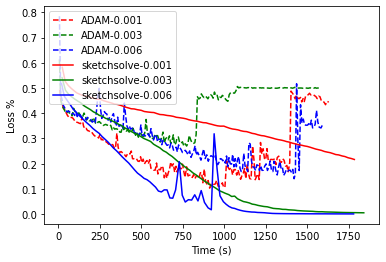

In [106]:
plt.ylabel("Loss %")
plt.xlabel("Time (s)")
plt.plot(timelist_sgd[10], losslist_sgd[10], 'r--', timelist_sgd[12], losslist_sgd[12], 'g--', 
         timelist_sgd[15], losslist_sgd[15], 'b--', timelist_nyssolve[0], losslist_nyssolve[0], 'r-', 
        timelist_nyssolve[2], losslist_nyssolve[2], 'g-', timelist_nyssolve[5], losslist_nyssolve[5], 'b-')
plt.legend(["ADAM-0.001", "ADAM-0.003", "ADAM-0.006", "sketchsolve-0.001", "sketchsolve-0.003", "sketchsolve-0.006"])
plt.show()

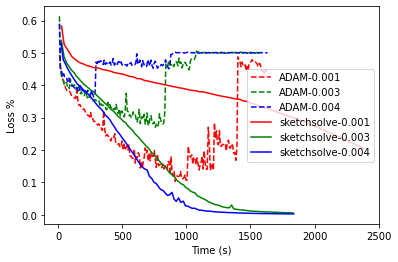

In [125]:
# 150 interval
plt.ylabel("Loss %")
plt.xlabel("Time (s)")
plt.plot(timelist_sgd[10], losslist_sgd[10], 'r--', timelist_sgd[12], losslist_sgd[12], 'g--', 
         timelist_sgd[13], losslist_sgd[13], 'b--', timelist_nyssolve_2[0], losslist_nyssolve_2[0], 'r-', 
        timelist_nyssolve_2[2], losslist_nyssolve_2[2], 'g-', timelist_nyssolve_2[3], losslist_nyssolve_2[3], 'b-')
plt.legend(["ADAM-0.001", "ADAM-0.003", "ADAM-0.004", "sketchsolve-0.001", "sketchsolve-0.003", "sketchsolve-0.004"])
plt.show()

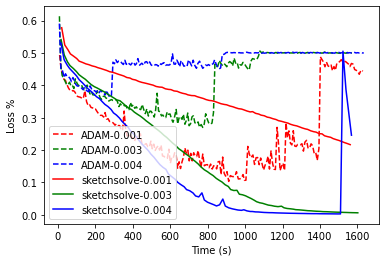

In [134]:
# 300 interval
plt.ylabel("Loss %")
plt.xlabel("Time (s)")
plt.plot(timelist_sgd[10], losslist_sgd[10], 'r--', timelist_sgd[12], losslist_sgd[12], 'g--', 
         timelist_sgd[13], losslist_sgd[13], 'b--', timelist_nyssolve_2[0], losslist_nyssolve_2[0], 'r-', 
        timelist_nyssolve_2[2], losslist_nyssolve_2[2], 'g-', timelist_nyssolve_2[3], losslist_nyssolve_2[3], 'b-')
plt.legend(["ADAM-0.001", "ADAM-0.003", "ADAM-0.004", "sketchsolve-0.001", "sketchsolve-0.003", "sketchsolve-0.004"])
plt.show()

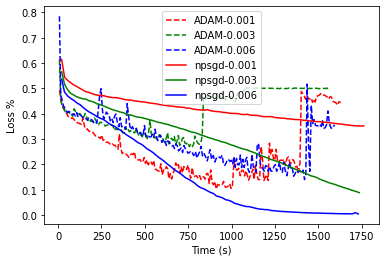

In [107]:
plt.ylabel("Loss %")
plt.xlabel("Time (s)")
plt.plot(timelist_sgd[10], losslist_sgd[10], 'r--', timelist_sgd[12], losslist_sgd[12], 'g--', 
         timelist_sgd[15], losslist_sgd[15], 'b--', timelist_nyspsgd[0], losslist_nyspsgd[0], 'r-', 
        timelist_nyspsgd[2], losslist_nyspsgd[2], 'g-', timelist_nyspsgd[5], losslist_nyspsgd[5], 'b-')
plt.legend(["ADAM-0.001", "ADAM-0.003", "ADAM-0.006", "npsgd-0.001", "npsgd-0.003", "npsgd-0.006"])
plt.show()

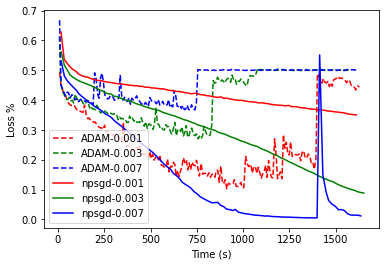

In [144]:
# 300 interval
plt.ylabel("Loss %")
plt.xlabel("Time (s)")
plt.plot(timelist_sgd[10], losslist_sgd[10], 'r--', timelist_sgd[12], losslist_sgd[12], 'g--', 
         timelist_sgd[16], losslist_sgd[16], 'b--', timelist_nyspsgd_2[0], losslist_nyspsgd_2[0], 'r-', 
        timelist_nyspsgd_2[2], losslist_nyspsgd_2[2], 'g-', timelist_nyspsgd_2[6], losslist_nyspsgd_2[6], 'b-')
plt.legend(["ADAM-0.001", "ADAM-0.003", "ADAM-0.007", "npsgd-0.001", "npsgd-0.003", "npsgd-0.007"])
plt.show()

In [ ]:
hes_interval = 150
# update Hessian and Nystrom sketch every couple of steps
hes_iter = 0

timelist_linesearch = []
losslist_linesearch = []
acclist_linesearch = []

start_time = timeit.default_timer()

model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    
    for X_batch, y_batch in train_loader:
        
        if hes_iter % hes_interval == 0:
            # update Hessian and sketch
            optimizer.nysh.update_Hessian(X_batch, y_batch, model, criterion, device)
        
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        hes_iter += 1
        epoch_time = timeit.default_timer()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    losslist2.append(epoch_loss/len(train_loader))
    timelist2.append(epoch_time - start_time)
    acclist2.append(epoch_acc/len(train_loader))